## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns

In [2]:
reviews = pd.read_csv("data/steam_reviews.csv")
games_overiews = pd.read_csv("data/game_overview.csv")

In [3]:
reviews

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1
...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1


In [4]:
games_overiews

,title,developer,publisher,tags,overview
0,Spooky's Jump Scare Mansion,Lag Studios,Lag Studios,"['Horror', 'Free to Play', 'Cute', 'First-Pers...",Can you survive 1000 rooms of cute terror? Or ...
1,Sakura Clicker,Winged Cloud,Winged Cloud,"['Nudity', 'Anime', 'Free to Play', 'Mature', ...",The latest entry in the Sakura series is more ...
2,WARMODE,WARTEAM,WARTEAM,"['Early Access', 'Free to Play', 'FPS', 'Multi...",Free to play shooter about the confrontation o...
3,Fractured Space,Edge Case Games Ltd.,Edge Case Games Ltd.,"['Space', 'Multiplayer', 'Free to Play', 'PvP'...",Take the helm of a gigantic capital ship and g...
4,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'T...",Counter-Strike: Global Offensive (CS: GO) expa...
...,...,...,...,...,...
59,Bloons TD Battles,Ninja Kiwi,Ninja Kiwi,"['Free to Play', 'Tower Defense', 'Multiplayer...",Play the top-rated tower defense franchise in ...
60,Cuisine Royale,Darkflow Software,Gaijin Distribution KFT,"['Early Access', 'Free to Play', 'Battle Royal...",Cuisine Royale is an all-kitchen-warfare Battl...
61,GUNS UP!,"Valkyrie Entertainment, LLC","PlayStation Mobile, Inc.","['Free to Play', 'Strategy', 'Multiplayer', 'A...","In a mashup of RTS & Tower Defense, GUNS UP! i..."
62,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","['Free to Play', 'Dragons', 'Adventure', 'Mult...",**Changewing Dragon now Available**Fly Fast. T...


W zadaniu wykorzystamy tylko recenzje użytkowników **user_review** oraz **user_suggestion** (czyli nasz target).

In [25]:
df = reviews[['user_review', 'user_suggestion']]
df

,user_review,user_suggestion
0,"I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times. This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean'). Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd. I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",1
1,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.",1
2,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it to floor 1000 before, but due to certain circumstances was unable to finish. Was not game related, don't worry, not a bug/glitch or antyhing.I highly recommend this for casual play, maybe with a friend or two watching. Hilarity ensues, especially once you hit floor 150. Have fun my fellow fleshlings!",1
3,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!",1
4,"Not many games have the cute tag right next to the horror tag on Steam.I first played this game in late 2014 and coming back to it for the first time since. This game is so good for it being free, take advantage and experience it. Try and get to room 1000 or as close as you can. The further you progress the darker the game becomes.",1
...,...,...
17489,"Arguably the single greatest mmorp that exists today, and now its free!!!! There is little to no competition for this game. Graphics that bend to a weak ♥♥♥♥♥♥ computer, as well as an extreme graphics option offering the most insanely beautiful graphics a pc game has every brought you, but i warn you, even the most high end computers have a hard time handling extreme mode ;) mine rocks it but yeah.Many classes, and races.however you must pay to unlock classes, (well worth the money considering the game is free now) but you dont need to pay to unlock all the classes or races, you can just buy one you want. Appearance armor that goes on over your currently equipped gear and weapons, keep the stats, and the style. Huge guilds, with guild halls you can create that are vast decorative buildings, many houses and house items to create and craft or find.God quests that take you on expansive journies to connect your ties with the chosen of the land. Huge raid dungeons. and more.",1
17490,"An older game, to be sure, but has its own charm and holds a special place in my heart - having played it since I was young. Definitely still has some grind if you want to run through *all* of the content, but if someone just wanted to get right into the action, I'm fairly certain he or she could get up to speed quickly. Pretty expansive variety of races and classes, with few restrictions if any (evil races can play as good classes by betraying and vice versa).I would still recommend buying a subscription if you want to play endgame content (removes most limitations), and unfortunately there are a couple extra features that need to be bought outside of that, but if you buy the sub, you can collect the credits to get those free of charge anyhow. Not sure how playing free through the whole game would be, but I'm sure it's both viable and still fun.The lore in t

In [6]:
df['user_suggestion'].value_counts()

user_suggestion
1    9968
0    7526
Name: count, dtype: int64

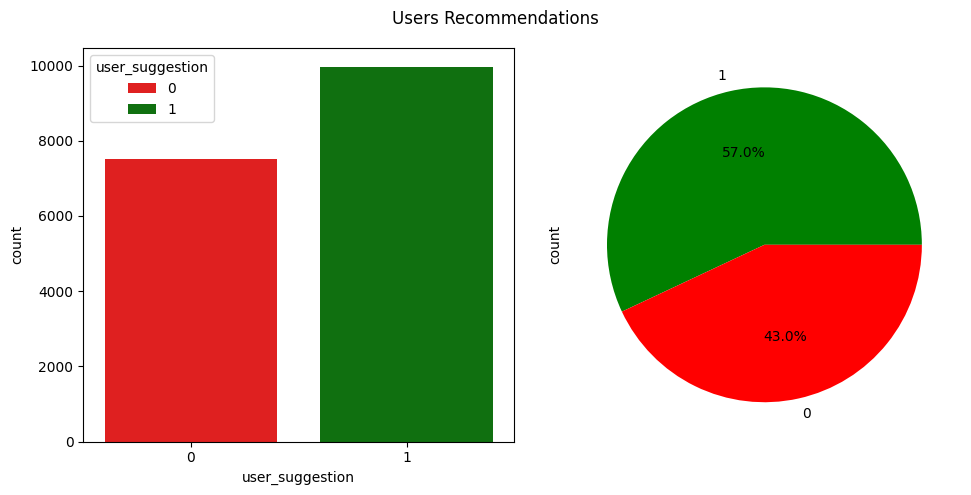

In [7]:
color_dict = {0: "red", 1: "green"}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='user_suggestion', data=df, hue='user_suggestion', palette=[color_dict[0], color_dict[1]], ax=axs[0])
df['user_suggestion'].value_counts().plot.pie(autopct='%1.1f%%', colors=[color_dict[1], color_dict[0]], ax=axs[1])
fig.suptitle('Users Recommendations')
plt.tight_layout()

In [27]:
pd.set_option('display.max_colwidth', None)
df.sample(20)

,user_review,user_suggestion
10673,"Early Access ReviewGreat game, lots of fun play modes against other players or the AI, lots of free rewards and daily quests to start the game and accumulate the cards, even going the free to play route. Regular balance patches and epansions, a diverse meta of aggro, mid range and control decks, and lots of content to explore!Great game allaorund, I really enjoy playing it and urge you to try it, too!Make sure to check out the subreddit at www.reddit.com/r/eternalcardgame and www.eternalwarcry.com as well!",1
17179,"Product received for freedo not forget ww2 .albiania we kill the king , albania return to your precious mongolia....hahahahaha idiot turk and bosnian smell so bad..wow i can smell it. REMOVE KEBAB FROM THE PREMISES. you will get caught. russia+usa+croatia+slovak=kill bosnia...you will ww2/ tupac alive in serbia, tupac making album of serbia . fast rap tupac serbia. we are rich and have gold now hahahaha ha because of tupac... you are ppoor stink turk... you live in a hovel hahahaha, you live in a yurttupac alive numbr one #1 in serbia ....♥♥♥♥ the croatia ,..♥♥♥♥k ashol turks no good i spit in the mouth eye of ur flag and contry. 2pac aliv and real strong wizard kill all the turk farm aminal with rap magic now we the serba rule .ape of the zoo presidant georg bush fukc the great satan and lay egg this egg hatch and bosnia wa;s born. stupid baby form the eggn give bak our clay we will crush u lik a skull of pig. serbia greattst countrey",1
9237,"Planetside 2 is one of those games with an unusual combination of genres. However, it works in this game's advantage, because it is worked out really well.Coming back to my point earlier, a fps mixed with a MMO isn't the combination you think of when making a game. Or it is, but very hard to work out. Planetside 2 did this very well. There are 3 unique worlds where you aim for domination by claiming land as your own. There are also 3 teams/replubics who are part of this battle. In short, only 1 world already contains thousands of players, duking it out to be the victor. That is just so much fun and works correctly.There are 6 classes to choose from, so you can choose the character that fits you the most. Your class has different weapons and styles depending on the replubic you choose. This also comes in the form of varying vehicles, which also work very well in this game. There are both land vehicles and airplanes, and both are easy to handle once you get the hang on it.It will take some time before you have built your character with customizations and weapons, but trust me, it is definitely worth it. And if you're not sure about what weapon to choose, you can hire them for some time or test them out for free as much as you want in the training section.There are 3 worlds in total. One being Indar, the kind of desert world. Most of the time that world is also most crowed. On the other hand you have Esamir, the snow world. This one is usually the most quiet. And finally, there is Amerish, which is a Jungle world. This one is mixed on people.There is one negative point that I also have to mention. That one being Character Customization, which is not or almost not part of this game. Everybody looks the exact same depending on your class. You are able to give you armor and weapons several colors, but this will cost you real life money, and it is not worth it.Planetside 2 is definitely worth checking out. I would advice picking this up with friends though, because it can be a bit boring when you go alone.",1
17380,"game is buggier than sonic 06, gameplay is like superman 64, loading screens are longer than the actual game, it won't let me create an account, and the chat is more censored than north korean public media.10/10 MASTERPIECE -IGN",1
13238,The store prices are stupid high. They are 4 times what they should be. So me recomending this game is saying I think this is fine. I do not beleive it is. So I will not give a thumbs up.The game is a

Po przejrzeniu danych można zauważyć, że część recenzji zawiera wyrażenie "Early Access Review". Jest to zaledwie informacja, że recenzja została wystawiona dla gry, która nie miała oficjalnej premiery. W kontekście analizy sentymentu nie ma to dla nas żadnego znaczenia, więc należy je usunąć.

In [28]:
# Testowy pojedynczy przykład - przed usunięciem Early Access Review
df.loc[6429, 'user_review']

'Early Access ReviewDo not play this and if you do, don\'t play as Germany because they were originally a fair opponet until "The Great Nerfining" were they they got nerfed so much that they have to pay royalties to Nerf. And defitinly don\'t play as tanker because 99% of the time you will get killed by and infantry to the point you fear them more then tank destroyers which are tanks meant for destroying other tanks. And don\'t forget the PTRD which one shots infantry, cars, light/medium/heavy/destroyers with it\'s infinite range accuracy and damage. Seriously developers fix the god damn game rather than adding in more and more half baked content that is pointless or makes the game even harder for german players which already have it hard enough. Why the hell am I even saying anything the developers won\'t listen to the community. Also did i mention to FIX THE GOD DAMN SERVERS BEING HOSTED ON PLUTO ALL THE TIME LIKE JESUS CHRIST!'

In [29]:
df.loc[:, 'user_review'] = df['user_review'].str.replace(r'Early Access Review(?=\S|$)', '', regex=True)

In [30]:
# Testowy pojedynczy przykład - po usunięciu Early Access Review
df.loc[6429, 'user_review']

'Do not play this and if you do, don\'t play as Germany because they were originally a fair opponet until "The Great Nerfining" were they they got nerfed so much that they have to pay royalties to Nerf. And defitinly don\'t play as tanker because 99% of the time you will get killed by and infantry to the point you fear them more then tank destroyers which are tanks meant for destroying other tanks. And don\'t forget the PTRD which one shots infantry, cars, light/medium/heavy/destroyers with it\'s infinite range accuracy and damage. Seriously developers fix the god damn game rather than adding in more and more half baked content that is pointless or makes the game even harder for german players which already have it hard enough. Why the hell am I even saying anything the developers won\'t listen to the community. Also did i mention to FIX THE GOD DAMN SERVERS BEING HOSTED ON PLUTO ALL THE TIME LIKE JESUS CHRIST!'

In [32]:
df.loc[857, 'user_review']

'Product received for freeVery good game, Much like Call Of Duty but still a lot of skill involved. If this game keeps updating and getting better this could be a big game'

Oprócz taga "Early Access Review" występuje także "Product received for free", który często występował w parze z tym pierwszym. Jako że usunęliśmy już "Early Access Review", możemy zastosować ten sam regex dla "Product received for free".

In [33]:
df.loc[:, 'user_review'] = df['user_review'].str.replace(r'Product received for free(?=\S|$)', '', regex=True)

In [34]:
df.loc[857, 'user_review']

'Very good game, Much like Call Of Duty but still a lot of skill involved. If this game keeps updating and getting better this could be a big game'

Oprócz tagów, recenzje zawierają wiele znaków specjalnych...

In [35]:
df.loc[128, 'user_review']

'░░░░░░░░░░░▄▐░░░░░░▄▄▄░░▄██▄░░░░░▐▀█▀▌░░░░▀█▄░░░░░▐█▄█▌░░░░░░▀█▄░░░░░░▀▄▀░░░▄▄▄▄▄▀▀░░░░▄▄▄██▀▀▀▀░░░█▀▄▄▄█░▀▀░░░▌░▄▄▄▐▌▀▀▀▄░▐░░░▄▄░█░▀▀ U HAVE BEEN SPOOKED BY THE▀█▌░░░▄░▀█▀░▀░░░░░░░▄▄▐▌▄▄░░░░░░░▀███▀█░▄░░░░░░▐▌▀▄▀▄▀▐▄SPOOKY SKILENTON░░░░░░▐▀░░░░░░▐▌░░░░░░█░░░░░░░░█░░░░░▐▌░░░░░░░░░█░░░░░█░░░░░░░░░░▐▌'

In [36]:
df.loc[190, 'user_review']

'░░░░░░░░░░░░▄▐ ░░░░░░░░░░░▄██▄ ░░░░░( ͡° ͜ʖ ͡°)░░░░░▀█▄ ░░░░░░░░░░░░░░░░▀█ ░░░░▄▄▄██▀▀▀▀▄▄▄▄▄▀▀ ░░░█▀▄▄▄█░▀▀ ░░░▌░▄▄▄▐▌▀▀▀ ▄░▐░░░▄▄░█░▀▀ ▀█▌░░░▄░▀█▀░▀ ░░░░░░░▄▄▐▌▄▄ ░░░░░░░▀███▀█░▄ ░░░░░░▐▌▀▄▀▄▀▐▄ ░░░░░░▐▀░░░░░░▐▌ ░░░░░░█░░░░░░░░█ ░░░░░▐▌░░░░░░░░░█ ░░░░░█░░░░░░░░░░▐▌'

In [39]:
df.loc[193, 'user_review']

'░░░░░░░░░░░█▀▀░░█░░░░░░░░░░░░▄▀▀▀▀░░░░░█▄▄░░░░░░░░░░█░█░░░░░░░░░░▐░░░ ░░░░░░▐▐░░░░░░░░░▄░▐░░░░░░░░░█░░░░░░░░▄▀▀░▐░░░ ░░░░▄▀░░░░░░░░▐░▄▄▀░░░░ ░░▄▀░░░▐░░░░░█▄▀░▐░░░░░ ░░█░░░▐░░░░░░░░▄░█░░░░░ ░░░█▄░░▀▄░░░░▄▀▐░█░░░░░ ░░░█▐▀▀▀░▀▀▀▀░░▐░█░░░░░ ░░▐█▐▄░░▀░░░░░░▐░█▄▄░░░ ░░▀▀░▄spooky▄░▐▄▄▄▄▀  ░░░░░░house of jumpscares  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░'

In [41]:
df.loc[232, 'user_review']

"....................../´¯/) ....................,/¯../ .................../..../ ............./´¯/'...'/´¯¯`·¸ ........../'/.../..../......./¨¯\\ ........('(...´...´.... ¯~/'...') .........\\.................'...../ ..........''...\\.......... _.·´ ............\\..............( ..............\\.............\\...Too spooky"